In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
from pathlib import Path
import tiktoken
import matplotlib.pyplot as plt
import time
import inspect

In [3]:
!nvidia-smi

Thu Jul 31 01:26:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |
| N/A   39C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
torch.manual_seed(1337)
shake_data = Path('/home/ubuntu/data/input.txt')


def get_device():
    device = 'cpu'
    if torch.cuda.is_available():
        torch.cuda.manual_seed(1337)
        device = 'cuda'
    # elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    #     device = 'mps'
    print(f'using {device}')
    return device

device = get_device()

using cuda


## Model

In [5]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        # ensures that you can split embeddings across the heads
        assert config.n_embd % config.n_head == 0
        # key, query, value projection for all heads in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # acts as a triangle mask to prevent seeing the future, called bias for historic reasons
        self.register_buffer('bias', torch.tril(torch.ones(config.block_size, 
                                                           config.block_size)
                                               ).view(1,1, config.block_size,config.block_size)
                            )

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, n_embd embedding dimensionality 
        # calculate query, key, value for all heads in batch, then move head forward
        # nh - num heads, hs - head size, C  nh*hs aka channels
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        # attention (materializes the large (T,T) matrix for all the queries and keys)
        # att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        # att = F.softmax(att, dim=-1)
        # y = att @ v # (B, nh, T, T) X (B, nh, T, hs) - > (B, nh, T, hs)
        # replace attention with flash attention 
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        # allows for pathway to pass through gradients instead of going through each "box"
        # this is a feed forward network
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length/context
    vocab_size: int = 50257 # num of tokens, 50k merges, 256 bytes, 1 EOT
    n_layer: int = 12 
    n_head: int = 12
    n_embd: int = 768

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd), # weight tokenizer element
            wpe = nn.Embedding(config.block_size, config.n_embd), # weight position element
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]), # hidden layers aka Transformers
            ln_f = nn.LayerNorm(config.n_embd), #log normalization 
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias = False) # language model head going from embeddings to vocab

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        mean = 0.0
        if isinstance(module, nn.Linear):
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=mean, std=std)

    def forward(self, idx, targets=None):
        # idx is shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f'Cannot forward sequence, out of context'
        # forward the token and positions
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        pos_emb = self.transformer.wpe(pos) # (T, n_embd)
        tok_emb = self.transformer.wte(idx) # (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the block
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and head
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss
    
    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, device_type):
        # start with all of the candidate parameters (that require grad)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == "cuda"
        print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        return optimizer


class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T
        with open(shake_data, 'r', encoding='utf-8') as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f'loaded {len(self.tokens)} tokens')
        print(f'1 epoch = {len(self.tokens) // (B*T)} batches')

        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position+B*T+1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B * T 
        # if loading the next batch would be out of bounds, advance to next shard
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y

## Create model for training

In [6]:
total_batch_size = 2**17 #524288 # 2**19, ~0.5M, in number of tokens
B = 4 # micro batch size
T = 1024 # sequence length
assert total_batch_size % (B * T) == 0, "make sure total_batch_size is divisible by B * T * ddp_world_size"
grad_accum_steps = total_batch_size // (B * T)
print(f"total desired batch size: {total_batch_size}")
print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")

train_loader = DataLoaderLite(B=B, T=T)
torch.set_float32_matmul_precision('high')

model = GPT(GPTConfig(vocab_size=50304)) # make divisible by power of 2
model.to(device)
model = torch.compile(model)
lossi = []

total desired batch size: 131072
=> calculated gradient accumulation steps: 32
loaded 338025 tokens
1 epoch = 82 batches


In [7]:
max_lr = 6e-4
min_lr = max_lr * 0.1
max_steps = 200
warmup_steps = 0.2 * max_steps # 20% warmup
weight_decay = 0.1
def get_lr(it):
    # 1/ linear warmup 
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2/ if iterations > lr_decay_iters, return min learning rate
    if it > max_steps: 
        return min_lr

    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

In [8]:
#optimizer = torch.optim.AdamW(model.parameters(), lr=min_lr, betas=(0.9, 0.95), eps=1e-8)
optimizer = model.configure_optimizers(weight_decay=weight_decay, learning_rate=max_lr, device_type=device)
enc = tiktoken.get_encoding('gpt2')

num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True


In [9]:
for step in range(max_steps):
    t0 = time.time()
    last_step = (step == max_steps - 1)
    
    # once in a while generate from the model (except step 0, which is noise)
    if ((step > 0 and step % 10 == 0) or last_step):
        model.eval()
        num_return_sequences = 2
        max_length = 32
        tokens = enc.encode('Hello, I\'m a language model,')
        tokens = torch.tensor(tokens, dtype=torch.long)
        tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
        xgen = tokens.to(device)
        sample_rng = torch.Generator(device=device)
        sample_rng.manual_seed(42)
        while xgen.size(1) < max_length:
            # forward the model to get the logits
            with torch.no_grad():
                logits, loss = model(xgen)
                logits = logits[:, -1, :]
                probs = F.softmax(logits, dim=-1)
                topk_probs, topk_indices = torch.topk(probs, 50, dim=-1) # limit tensor size by sampling
                ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
                xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
                xgen = torch.cat((xgen, xcol), dim=1)
        # print the generated text
        for i in range(num_return_sequences):
            tokens = xgen[i, :max_length].tolist()
            decoded = enc.decode(tokens)
            print(f"sample {i}: {decoded}")
            
    
    optimizer.zero_grad()
    loss_accum = 0.0
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)
        
        #with torch.autocast(device_type=device, dtype=torch.bfloat16): # not supported on Tesla T4
        logits, loss = model(x, y)
        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward()
        #print(f'microstep {micro_step}/{grad_accum_steps} | loss {loss_accum}')
    
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clips gradient to avoid very high gradients that shock model 
    # set LR for this step
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    optimizer.step()
    torch.cuda.synchronize()
    t1 = time.time()
    dt = (t1-t0)*1000 # time diff in MS 
    print(f'step {step}: loss of {loss_accum.item()} with average time of {dt:.4f}ms | {lr:.4e}')
    lossi.append(loss_accum.item())

    if step > 0 and (step % 50 == 0 or last_step):
        cp_dir = Path('/home/ubuntu/model')
        cp_path = cp_dir / f'model_{step:05d}.pt'
        checkpoint = {
            'model': model.state_dict(),
            'config': model.config,
            'step': step, 
            'val_loss': loss_accum.item()
        }
        torch.save(checkpoint, cp_path)

step 0: loss of 10.967737197875977 with average time of 31975.6780ms | 1.5000e-05
step 1: loss of 10.585558891296387 with average time of 29923.0061ms | 3.0000e-05
step 2: loss of 9.96261978149414 with average time of 30190.4178ms | 4.5000e-05
step 3: loss of 9.541036605834961 with average time of 30271.9138ms | 6.0000e-05
step 4: loss of 9.232091903686523 with average time of 30375.6015ms | 7.5000e-05
step 5: loss of 9.048246383666992 with average time of 30392.0698ms | 9.0000e-05
step 6: loss of 8.935154914855957 with average time of 30391.7952ms | 1.0500e-04
step 7: loss of 8.721705436706543 with average time of 30444.3164ms | 1.2000e-04
step 8: loss of 8.678725242614746 with average time of 30400.0356ms | 1.3500e-04
step 9: loss of 8.512798309326172 with average time of 30432.2765ms | 1.5000e-04
sample 0: Hello, I'm a language model,



,














:



sample 1: Hello, I'm a language model,








:






:
,




step 10: loss of 8.303852081298828 with average time of 32989.5

KeyboardInterrupt: 

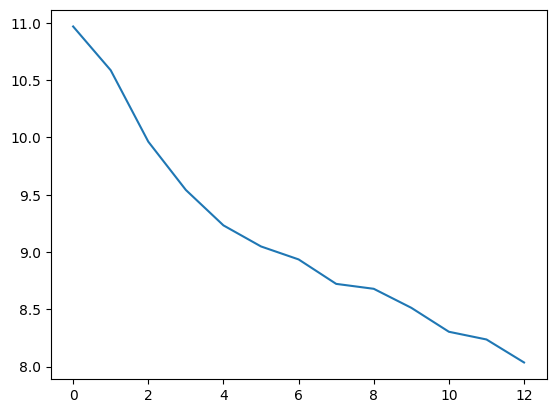

In [10]:
plt.plot(lossi)

In [11]:
step = 12
cp_dir = Path('/home/ubuntu/model')
cp_path = cp_dir / f'model_{step:05d}.pt'
checkpoint = {
    'model': model.state_dict(),
    'config': model.config,
    'step': step, 
    'val_loss': loss_accum.item()
}
torch.save(checkpoint, cp_path)

In [12]:
!nvidia-smi

Thu Jul 31 01:33:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |
| N/A   49C    P0             35W /   70W |    7525MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Generate samples

In [13]:
model.eval()
num_return_sequences = 2
max_length = 32
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode('Hello, I\'m a language model,')
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
xgen = tokens.to(device)
sample_rng = torch.Generator(device=device)
sample_rng.manual_seed(42)
while xgen.size(1) < max_length:
    # forward the model to get the logits
    with torch.no_grad():
        logits, loss = model(xgen)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1) # limit tensor size by sampling
        ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        xgen = torch.cat((xgen, xcol), dim=1)
# print the generated text
for i in range(num_return_sequences):
    tokens = xgen[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(f"sample {i}: {decoded}")

sample 0: Hello, I'm a language model,



And














:



sample 1: Hello, I'm a language model,








, her





,






